In [45]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import math
from tensorflow import keras
from sklearn.preprocessing import normalize
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.models import load_model
from collections import defaultdict

In [2]:
def loadDataFiles():
    market_df = pickle.load(open('Market_train',"rb"))
    news_df = pickle.load(open("News_train", "rb"))
    print('Finished loading datafiles!')
    return market_df, news_df


In [3]:
def preprocess_data(mkt_df, news_df):
    mkt_df['time'] = pd.to_datetime(mkt_df['time'])
    news_df['time'] = pd.to_datetime(news_df['time'])
    mkt_df['time'] = mkt_df['time'].dt.date
    news_df['time'] = news_df['time'].dt.date
    assetCodes = []
    index = 0
    for x in news_df['assetCodes']:
        x = x.split(',')[0].split("'")[1]
        assetCodes.append(x)
    news_df['assetCode'] = np.asarray(assetCodes)
    irrelevantColumns = ['sourceTimestamp', 'firstCreated', 'sourceId', 
                         'headline', 'provider', 'subjects', 'audiences',
                        'headlineTag', 'marketCommentary', 'assetCodes', 'assetName']
    news_df.drop(irrelevantColumns, axis=1, inplace=True)
    mkt_df.drop(['assetName'], axis=1, inplace=True)
    modifiednews = news_df.groupby(['time','assetCode'], sort=False).aggregate(np.mean).reset_index()
    
    # join news reports to market data, note many assets will have many days without news data
    merged = pd.merge(mkt_df, modifiednews, how='left', on=['time', 'assetCode'], copy=False) 
    merged = merged.fillna(0)
    print('Finished preprocessing data!')
    return merged


In [4]:
market_data, news_data = loadDataFiles()


Finished loading datafiles!


In [5]:
X = preprocess_data(market_data, news_data)


Finished preprocessing data!


In [6]:
X = X[X['returnsOpenNextMktres10'] >= -1]
X = X[X['returnsOpenNextMktres10'] <= 1]
y = X['returnsOpenNextMktres10']
X.drop(['returnsOpenNextMktres10'], axis=1, inplace=True)
assetCodesAndTime = X.iloc[:, :2]
X = X.iloc[:, 2:]

1994287


In [7]:
def regularize(df):
    for column in df:
        colmin = np.amin(df[column])
        colmax = np.amax(df[column])
        df[column] = (df[column] - colmin) / (colmax - colmin)
    return df

In [8]:
X = regularize(X)

In [9]:
def saveModel(model, model_name):
    model.save(model_name + '.h5')

In [10]:
def loadModel(filename):
    model = load_model(filename)
    return model

In [11]:
def splitDataset(X, y, split):
    index = int(split*len(y.index))
    y_train, y_test = np.split(y, [index])
    X_train, X_test = X.iloc[:index, :], X.iloc[index:, :]
    return X_train, y_train, X_test, y_test

In [12]:
X = regularize(X)
X_train, y_train, X_test, y_test = splitDataset(X, y, 0.7)

1374968
619319


In [19]:
def modify_Y(y):
    y[y > 0] = 1
    y[y <= 0] = 0
    return y

In [20]:
y_train_copy = np.copy(y_train)
y_test_copy = np.copy(y_test)
y_train_new = modify_Y(y_train_copy)
y_test_new = modify_Y(y_test_copy)

[1. 0. 1. ... 1. 1. 0.]


In [49]:
clf = GaussianNB()
clf.fit(X_train, y_train_new)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_score = clf.fit(X_train, y_train_new).predict_log_proba(X_test)
false_positive_rate, true_positive_rate, _ = roc_curve(y_test_new, y_score[:,1])

[[-1.20330046e-01 -2.17707872e+00]
 [-1.24680533e-08 -1.82000962e+01]
 [-1.60269500e-01 -1.90996322e+00]
 ...
 [-8.53628904e-02 -2.50322166e+00]
 [-9.45003468e-02 -2.40602988e+00]
 [-1.20229783e-01 -2.17786317e+00]]


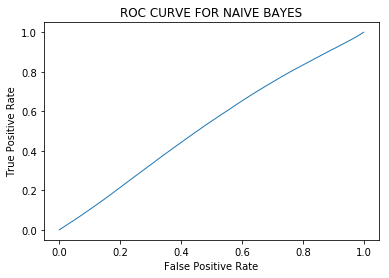

In [48]:
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE FOR NAIVE BAYES")
plt.plot(false_positive_rate, true_positive_rate, linewidth=1)
plt.show()